# Reinforcement Learning Lab

<img src="https://miro.medium.com/v2/resize:fit:2000/0*WC4l7u90TsKs_eXj.png" width=500px>


In this notebook, we explore different strategy for Reinforcement Learning for a simple control task, Cart Pole, first introduced by Sutton, Barto and Anderson [1]. We will mainly use PyTorch and Gymnasium, a popular library containing some basic building blocks for training RL agent.

- Gym: https://gymnasium.farama.org/

## Quick-start Setup
```bash
conda create --name ml_labs python=3.10
conda activate ml_labs
conda install -c conda-forge jupyterlab scikit-learn pandas
pip install matplotlib gymnasium tqdm
pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
jupyter lab
```

### Structure
- SARSA
- Q-Learning
- Deep Q-Learning

[1] A. G. Barto, R. S. Sutton and C. W. Anderson, "Neuronlike adaptive elements that can solve difficult learning control problems," in IEEE Transactions on Systems, Man, and Cybernetics, vol. SMC-13, no. 5, pp. 834-846, Sept.-Oct. 1983, doi: 10.1109/TSMC.1983.6313077.


## Cart Pole Environment

<img src="https://gymnasium.farama.org/_images/cart_pole.gif" height="200" />

A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.

- **Action Space**: push right or push left the cart;
- **Observation Space**: cart position and velocity, pole angle and velocity. All the features are continuous.
- **Reward**: +1 for each timestep we keep the pole upwards (in a certain angle). We have a maximum of 500 timestep.

An **episode** ends when either: make the pole fall, the cart reaches the edges of the line, or we reach 500 timesteps.

You can find the reference implementation [here](https://gymnasium.farama.org/environments/classic_control/cart_pole/).

In [3]:
import gymnasium as gym

from tqdm import tqdm
import pandas as pd
import numpy as np
import random

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Let us start by first importing the gym library.

In [4]:
# We create an environment
env = gym.make('CartPole-v1')

In [5]:
# Here we show some basic details on an Gym environment
env.observation_space.high

array([4.8       ,        inf, 0.41887903,        inf], dtype=float32)

In [6]:
# We reset the state to a new one
state, _ = env.reset()

# We perform a certain action and we get some info
new_state, reward, done, truncated, info = env.step(0)

SARSA and Q-Learning estimates a action-value function $Q(s,a)$. During the lecture, we usually assume the environment is discrete in order for $Q(s,a)$ to be learnable. Here, Cart Pole has a **continuous** environment instead, thus we need to perform a **discretization** step.

There are more sofisticated techniques for discretization (such as Tile Coding [2]) but we will not cover them here.

[2] http://www.incompleteideas.net/book/8/node6.html

In [7]:
# Set the random seed
random.seed(2024)
np.random.seed(2024)

def discretize(env, num_bins=10):
  """Discretize each feature into a given number of bins"""
  bins = []
  for feature_low, feature_high in zip(env.observation_space.low, env.observation_space.high):
    bins.append(
        np.linspace(max(-10, feature_low), min(10, feature_high), num=num_bins)
    )
  return bins

def convert_state(state, bins):
  """Given a continuous state, return its binned representation"""
  new_state = []
  for feature, feature_bins in zip(state, bins):
    new_state.append(
        np.digitize(feature, feature_bins)
    )
  return tuple(new_state)

Let us test our new function before actually using it.

In [8]:
bins = discretize(env)
state, _ = env.reset()
convert_state(state, bins)

(5, 5, 5, 5)

Let us now define a function which, given $Q(s,a)$ will play an episode of the environment. It will be useful later on.

In [9]:
def play(env, Q, bins):
  """Play an episode using the state-action function Q"""

  state, _ = env.reset()

  done = False
  truncated = False
  total_reward = 0

  while not done and not truncated:

    # env.render() Uncomment this line to see an interactive visualization of the agent
    # in the environment. It works only if this notebook is run as a simple python
    # script on your local environment.

    state = convert_state(state, bins)
    action = np.argmax(Q[state])
    next_state, reward, done, truncated, _ = env.step(action)
    state = next_state
    total_reward += reward

  return total_reward

We now define a function to solve the control task by using either SARSA or Q-Learning.

### SARSA (State-Action-Reward-Sate-Action)
<img src="https://tcnguyen.github.io/reinforcement_learning/images/SARSA_algo.png" height="300" />

### Q-Learning
<img src="https://tcnguyen.github.io/reinforcement_learning/images/Q_learning_algo.png" height="300" />





In [10]:
def SARSA(Q, bins, alpha=0.25, gamma=0.9, epsilon=0.3, episodes=100):
  """Implement the SARSA on-policy algorithm"""

  eval_results = []

  for episode in tqdm(range(episodes)):

    state, _ = env.reset()
    state = convert_state(state, bins)

    action = np.argmax(Q[state]) if np.random.rand() >= epsilon else env.action_space.sample()

    done = False
    truncated = False

    while not done and not truncated:

      next_state, reward, done, truncated, _ = env.step(action)
      next_state = convert_state(next_state, bins)

      next_action = np.argmax(Q[next_state]) if np.random.rand() >= epsilon else env.action_space.sample()

      # SARSA update rule
      Q[state][action] += alpha * (reward + gamma * Q[next_state][next_action] - Q[state][action])

      state, action = next_state, next_action

    # Evaluation step
    if episode % 10 == 0:
      for _ in range(5):
        eval_results.append(
           [episode, play(env, Q, bins)]
        )

  return Q, eval_results

In [11]:
def QLearning(Q, bins, alpha=0.25, gamma=0.9, epsilon=0.3, episodes=100):
  """Implement the Q-Learning off-policy algorithm"""
  eval_results = []

  for episode in tqdm(range(episodes)):

    state, _ = env.reset()

    done = False
    truncated = False

    while not done and not truncated:

      state = convert_state(state, bins)
      action = np.argmax(Q[state]) if np.random.rand() >= epsilon else env.action_space.sample()

      next_state, reward, done, truncated, _ = env.step(action)
      next_state_converted = convert_state(next_state, bins)

      # Q-Learning update rule
      Q[state][action] += alpha * (reward + gamma * max(Q[next_state_converted]) - Q[state][action])

      state = next_state

    # Evaluation step
    if episode % 10 == 0:
      for _ in range(5):
        eval_results.append(
           [episode, play(env, Q, bins)]
        )

  return Q, eval_results

Let us try to learn something!

In [12]:
# Define the environment
env = gym.make('CartPole-v1')

# Pick the high/low environment values
bins = discretize(env, num_bins=25)

# Initialize value function
Q = np.zeros([25,25,25,25,2])

In [13]:
Q_sarsa, eval_sarsa = SARSA(np.copy(Q), bins, episodes=5000)
Q_qlearn, eval_qlearning = QLearning(np.copy(Q), bins, episodes=5000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:22<00:00, 60.78it/s]


Given the evaluation results, we plot them and compare the two runs:

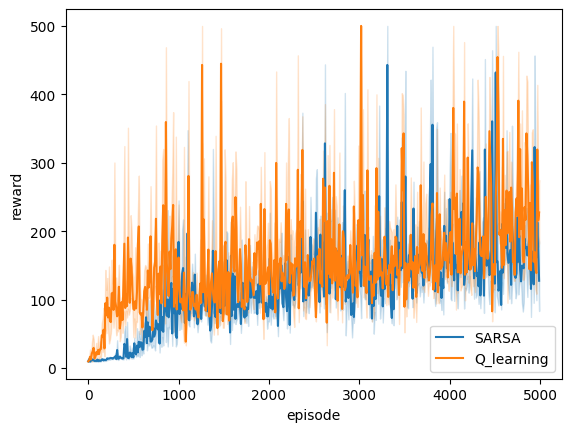

In [14]:
eval_sarsa = pd.DataFrame(eval_sarsa, columns=["episode", "reward"])
eval_qlearning = pd.DataFrame(eval_qlearning, columns=["episode", "reward"])

sns.lineplot(data=eval_sarsa, x="episode", y="reward", label="SARSA")
sns.lineplot(data=eval_qlearning, x="episode", y="reward", label="Q_learning")

plt.show()

# Deep Q-Learning

Deep Q-Learning is a technique to learn optimal policies which achieves superhuman performance on many Atari games [3]. It uses a neural network (NN) as a function approximator to learn the state-value utility function $Q(s,a)$ without resorting to discretization. Moreover, they exploit a techinque called _experience replay_ [4] where we store past episode of the agents to train the policy

The main components of such architecture are:
- A Feed-Forward neural network (3 layers, ReLu activations);
- A replay buffer containing the past experiences;

[3] Mnih, Volodymyr, et al. "Playing atari with deep reinforcement learning." arXiv preprint arXiv:1312.5602 (2013).

[4] Long-Ji Lin. Reinforcement learning for robots using neural networks. Technical report, DTIC
Document, 1993.

We want to train a neural network to minimize the following loss function:
$$ \mathcal L(\theta) = [ (r + \gamma\cdot\max_{a_{t+1} } Q(s_{t+1}, a_{t+1}; \theta^{target})) - Q(s_t, a_t; \theta^{pred}  )  ]^2  $$

The schematic is as follow:

<img src='https://miro.medium.com/v2/resize:fit:640/format:webp/1*nxn5uxtVBUniW1sTzjNbqQ.png'>

We first predict the Q-value associated to the current state $s_t$ and the chosen action $a_t$, then by oberving the next state $s_{t+1}$ of the environment the Q-value is computed by chosing the optimal action $a_{t+1}$.

In principle, $\theta^{pred}$ and $\theta^{target}$ can be two different neural networks, to avoid divergences.

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim

We define a replay buffer, which will contain all the agent states and rewards it experiences over training. This aids training effectively the Deep Q-Network.

In [16]:
class ReplayBuffer:
    """Replay buffer which will store all the experiences made by the agent"""
    def __init__(self, capacity):
        self.capacity = capacity
        self.storage = []

    def push(self, state, action, next_state, reward, done):

        self.storage.append([
            state, action, next_state, reward, done
        ])

        if len(self.storage) > self.capacity:
            self.storage.pop()

    def sample(self, batch_size):
      batch = np.random.randint(0, len(self), batch_size).tolist() if len(self) >= batch_size else list(range(len(self)))

      x, y, u, r, d = [], [], [], [], []

      for i in batch:
          X, Y, U, R, D = self.storage[i]
          x.append(np.array(X, copy=False))
          y.append(np.array(Y, copy=False))
          u.append(np.array(U, copy=False))
          r.append(np.array(R, copy=False))
          d.append(np.array(D, copy=False))

      return np.array(x), np.array(y), np.array(u), np.array(r).reshape(-1,1), np.array(d).reshape(-1,1)

    def __len__(self):
        return len(self.storage)

We then define our Q-network.

In [17]:
# Define Q-network
class QNetwork(nn.Module):
  """Q-Network component we will learn"""

  def __init__(self, input_size, hidden_size, output_size):
    super(QNetwork, self).__init__()
    self.fc = nn.Linear(input_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, hidden_size)
    self.fc3 = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    x = torch.relu(self.fc(x))
    x = torch.relu(self.fc2(x))
    return self.fc3(x)


At last, we can combine all this pieces to build the agent.

In [18]:
# DQN Agent
class DQNAgent:
    def __init__(self, input_size, hidden_size, output_size, epsilon=0.3, lr=1e-3, gamma=0.9):
      """Initialize all the components of the agent"""

      self.q_network = QNetwork(input_size, hidden_size, output_size)
      self.loss = nn.MSELoss()
      self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
      self.gamma = gamma
      self.epsilon = epsilon

    def select_action(self, state, greedy=False):
      """ Implement an epsilon-greedy action selection policy"""
      if np.random.random() <= self.epsilon and greedy:
            return torch.tensor([np.random.randint(0, len(self.q_network(state)))])
      else:
          with torch.no_grad():
            return  torch.tensor([torch.argmax(self.q_network(state))])

    def update_q_network(self, batch):
      """ Perform an optimization step given an experience batch"""

      state_batch, action_batch, next_state_batch, reward_batch, done_batch = batch

      state_batch = torch.FloatTensor(state_batch)
      next_state_batch = torch.FloatTensor(next_state_batch)
      action_batch = torch.LongTensor(action_batch)
      reward_batch = torch.FloatTensor(reward_batch)
      done_batch = torch.FloatTensor(1-done_batch)

      self.optimizer.zero_grad()

      predicted_q_value = self.q_network(state_batch).gather(1, action_batch)
      expected_q_value = reward_batch + done_batch * self.gamma * torch.max(self.q_network(next_state_batch), dim=1)[0].reshape(-1, 1)

      loss = self.loss(predicted_q_value, expected_q_value)
      loss.backward()
      self.optimizer.step()


Let us write the training script.

In [19]:
def deepQ(agent, env, buffer, num_episodes=500, batch_size=128):
  """Method which train a DQN agent."""

  eval_reward = []

  for episode in tqdm(range(num_episodes)):
    state = torch.tensor(env.reset()[0], dtype=torch.float32)

    while True:
        action = agent.select_action(state, greedy=True)
        next_state, reward, done, truncate, _ = env.step(action.item())

        buffer.push(state, action, torch.tensor(next_state), torch.tensor([reward]), torch.tensor([done]))

        # If the simulation has ended, stop here.
        if done or truncate:
          break

        # If we have enough samples, then we can train
        if len(buffer) >= batch_size:
          batch = buffer.sample(batch_size)
          agent.update_q_network(batch)

        state = torch.tensor(next_state)

    if (episode+1) % 10 == 0:

      for _ in range(5):
        state = torch.tensor(env.reset()[0], dtype=torch.float32)
        current_reward = 0

        while True:
            action = agent.select_action(state, greedy=True)
            next_state, reward, done, truncate, _ = env.step(action.item())
            state = torch.tensor(next_state, dtype=torch.float32) if not done else None
            current_reward += reward

            if done or truncate:
                break
        eval_reward.append([episode, current_reward])

  return eval_reward

Great! Now it is time to test our creation on the Cart Pole control problem.

In [20]:
# Initialize environment and agent
env = gym.make('CartPole-v1')
agent = DQNAgent(input_size=env.observation_space.shape[0], hidden_size=64, epsilon=0.3, output_size=env.action_space.n)

# Replay buffer
buffer = ReplayBuffer(15000)

# Training
num_episodes = 200
batch_size = 64

In [23]:
eval_deepQ = deepQ(agent, env, buffer, num_episodes, batch_size)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [03:10<00:00,  1.05it/s]


Then, we just print again the evaluation results

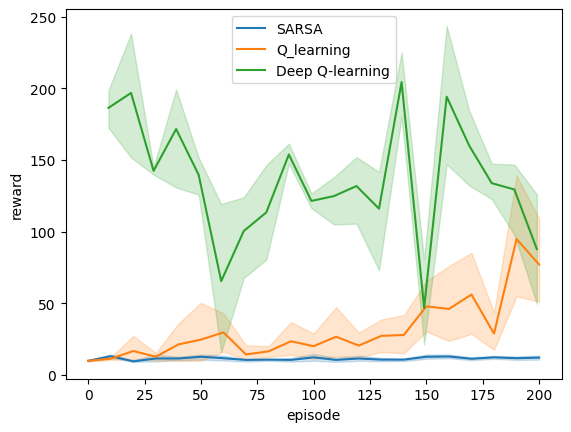

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

eval_deepQ = pd.DataFrame(eval_deepQ, columns=["episode", "reward"])

sns.lineplot(data=eval_sarsa[eval_sarsa.episode <= num_episodes], x="episode", y="reward", label="SARSA")
sns.lineplot(data=eval_qlearning[eval_sarsa.episode <= num_episodes], x="episode", y="reward", label="Q_learning")
sns.lineplot(data=eval_deepQ, x="episode", y="reward", label="Deep Q-learning")

plt.show()

## Additional Exercises

- Pick a new control environment from Gymnasium (e.g., Mountain Car) and try to learn an optimal state-action function.
- Implement Tile Coding to solve Cart Pole with SARSA/Q-Learning and compare it with Deep Q-Learning.
